In [16]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression, basemodel_regression, build_resnet
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.nonparametric.kernel_regression import KernelReg
import pickle as pkl

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

In [17]:
def train_dnn(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_dnn_reg(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [
                    callback, 
                    # early_stopping
                    ]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_regression(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [callback, early_stopping]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

# def heatmap(matrix, title, label):
#     save_path = 'plot/cm.png'
#     df=pd.DataFrame(matrix, index = label, columns = label)
#     plt.figure(figsize=(10,10))
#     sns.heatmap(df, annot=True, fmt = 'd')
#     plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
#     plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#     plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#     plt.xlabel("Prediction",position = (0.5,1.0+0.05))
#     plt.ylabel("Ground Truth")
#     plt.title(title)
#     plt.savefig('cm.png', format='png', dpi=300)

In [18]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [43]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            tmp = file.split('_')
            tmp[0] = tmp[0].zfill(2)
            createFolder('./'+path+'/' + tmp[0])
            shutil.move('./'+path+'/' + file, './'+path+'/' + tmp[0] + '/' + file)

In [50]:
def file_load(path):
    # data = list()
    file_list = os.listdir(path)
    data = None
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            # print(file_path)
            temp = np.load(file_path)
            if data is not None:
                data = np.concatenate((data, temp), axis = 0)
            else:
                data = temp
            # data.append(temp)
    return np.squeeze(data, axis = 1)

In [51]:
folder_path = 'counting_cylinder'
# folder_path = 'counting_disk'
# folder_path = 'counting'
# folder_path = 'countingdatasmall'

In [52]:
file_sort(folder_path)

In [53]:
folder_list = os.listdir(folder_path)

In [54]:
folder_list = sorted(folder_list)

In [55]:
temp_path = os.path.join(folder_path,folder_list[1])
data = file_load(temp_path)

In [56]:
data_dict = dict()
for folder in folder_list:
    temp_path = os.path.join(folder_path,folder)
    data_dict[folder] = np.array(file_load(temp_path))

In [ ]:
data_dict['02'].shape

(300, 301)

In [57]:
reshaped_data = data_dict
# reshaped_data = dict()
# for i in data_dict.keys():
#     reshaped_data[i] = data_dict[i].reshape(data_dict[i].shape[0]*data_dict[i].shape[1], data_dict[i].shape[2], data_dict[i].shape[3])
#     reshaped_data[i] = reshaped_data[i].reshape(reshaped_data[i].shape[0], reshaped_data[i].shape[2])

In [58]:
reshaped_data['00'].shape

(940, 301)

In [59]:
total_reshaped_data = [data for i in reshaped_data.keys() for data in reshaped_data[i]]
total_reshaped_data = np.array(total_reshaped_data)
total_reshaped_data.shape

minmax = MinMaxScaler()
minmax.fit(total_reshaped_data)
total_reshaped_data = minmax.transform(total_reshaped_data)
# scaler = StandardScaler()
# total_reshaped_data = scaler.fit_transform(total_reshaped_data)
# scaled_total_reshaped_data = scaler.transform(total_reshaped_data)
pca = PCA()
pca.fit(total_reshaped_data)

PCA()

In [60]:
pkl.dump(minmax, open('./preprocessed/minmax.pkl', 'wb'))
# pkl.dump(scaler, open('./preprocessed/scaler.pkl', 'wb'))
pkl.dump(pca, open('./preprocessed/pca.pkl', 'wb'))

In [61]:
range_fft_dict= dict()
for i in reshaped_data.keys():
    range_fft_dict[i] = np.fft.fftshift(np.fft.fft(reshaped_data[i], axis=1), axes=1)

In [62]:
reshaped_data['00'].shape

(940, 301)

In [63]:
def preprocessed(
        data, 
        # scaler, 
        minmax,
        pca
        ):
    # data = np.squeeze(data, axis = 1)
    data = minmax.transform(data)
    # data = scaler.transform(data)
    # data = pca.transform(data)
    # data = np.expand_dims(data, axis = 1)
    return data


# x = np.linspace(400, 1150, 301)
for i in reshaped_data.keys():
    # reshaped_data[i] = preprocessed(reshaped_data[i], scaler, pca)
    reshaped_data[i] = preprocessed(reshaped_data[i], minmax, pca)

In [64]:
# # 서브플롯 그리기
# num_profiles = len(range_fft_dict)
# plt.figure(figsize=(10, 5 * num_profiles))

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     plt.subplot(num_profiles, 1, idx)
#     plt.imshow(10 * np.log10(np.abs(profile)), aspect='auto', cmap='jet', interpolation='none')
#     # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
#     plt.colorbar(label="dB")
#     plt.xlabel("Range Bin")
#     plt.ylabel("Pulse Number")
#     plt.title(f"Range Profiles: {key}")

# plt.tight_layout()
# plt.show()

In [65]:
# # 그래프 그리기
# num_profiles = len(range_fft_dict)

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     Z = 10 * np.log10(np.abs(profile))
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

In [66]:
# num_profiles = len(reshaped_data)

# for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     # Z = 10 * np.log10(np.abs(profile))
#     Z = np.abs(profile)
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

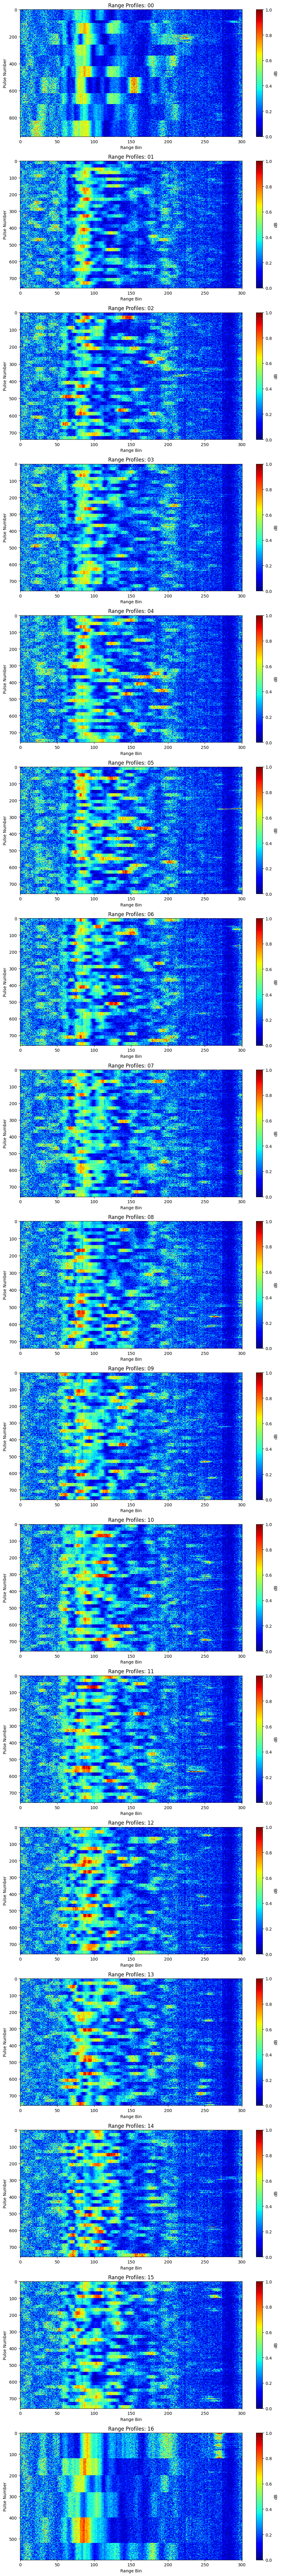

In [67]:
# 서브플롯 그리기
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

In [24]:
# model = basemodel(len(range_fft_dict))

In [68]:
def make_dataset(data_dict):
    # x = list()
    y = list()
    x = None
    for key, data in data_dict.items():
        if x is None:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
        for i in range(data.shape[0]):
            y.append(to_categorical(int(key), num_classes=len(data_dict)))
    print(x.shape)
    y = np.array(y)
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [69]:
# X_train, X_test, Y_train, Y_test = make_dataset(range_fft_dict)
# X_train, X_test  = 10 * np.log10(X_train), 10 * np.log10(X_test)
X_train, X_test, Y_train, Y_test = make_dataset(reshaped_data)
X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)

(12900, 301)


X shape :  (10320, 301)
Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  2416      
                                                                 
 batch_normalization_4 (Batc  multiple                 32        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             multiple                  144       
                                                                 
 dense_6 (Dense)             multiple                  544       
                                                                 
 dense_7 (Dense)             multiple                  2112      
                                                                 
 dense_8 (Dense)             multiple                  1105      
                                 

Epoch 1/500
322/323 [============================>.] - ETA: 0s - loss: 2.6422 - accuracy: 0.1422 - categorical_crossentropy: 2.6422INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 2.6412 - accuracy: 0.1427 - categorical_crossentropy: 2.6412 - val_loss: 2.4009 - val_accuracy: 0.2070 - val_categorical_crossentropy: 2.4009
Epoch 2/500
318/323 [============================>.] - ETA: 0s - loss: 2.2740 - accuracy: 0.2420 - categorical_crossentropy: 2.2740INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 2.2729 - accuracy: 0.2428 - categorical_crossentropy: 2.2729 - val_loss: 2.1133 - val_accuracy: 0.2884 - val_categorical_crossentropy: 2.1133
Epoch 3/500
318/323 [============================>.] - ETA: 0s - loss: 2.0564 - accuracy: 0.3080 - categorical_crossentropy: 2.0564INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 2.0545 - accuracy: 0.3078 - categorical_crossentropy: 2.0545 - val_loss: 1.9362 - val_accuracy: 0.3353 - val_categorical_crossentropy: 1.9362
Epoch 4/500
323/323 [==============================] - ETA: 0s - loss: 1.8847 - accuracy: 0.3589 - categorical_crossentropy: 1.8847INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 1.8847 - accuracy: 0.3589 - categorical_crossentropy: 1.8847 - val_loss: 1.8286 - val_accuracy: 0.3690 - val_categorical_crossentropy: 1.8286
Epoch 5/500
319/323 [============================>.] - ETA: 0s - loss: 1.7691 - accuracy: 0.3862 - categorical_crossentropy: 1.7691INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.7698 - accuracy: 0.3864 - categorical_crossentropy: 1.7698 - val_loss: 1.6868 - val_accuracy: 0.4031 - val_categorical_crossentropy: 1.6868
Epoch 6/500
320/323 [============================>.] - ETA: 0s - loss: 1.6827 - accuracy: 0.4140 - categorical_crossentropy: 1.6827INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.6828 - accuracy: 0.4138 - categorical_crossentropy: 1.6828 - val_loss: 1.6172 - val_accuracy: 0.4384 - val_categorical_crossentropy: 1.6172
Epoch 7/500
323/323 [==============================] - 3s 9ms/step - loss: 1.6152 - accuracy: 0.4375 - categorical_crossentropy: 1.6152 - val_loss: 1.6186 - val_accuracy: 0.4275 - val_categorical_crossentropy: 1.6186
Epoch 8/500
320/323 [============================>.] - ETA: 0s - loss: 1.5741 - accuracy: 0.4520 - categorical_crossentropy: 1.5741INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.5755 - accuracy: 0.4513 - categorical_crossentropy: 1.5755 - val_loss: 1.5219 - val_accuracy: 0.4624 - val_categorical_crossentropy: 1.5219
Epoch 9/500
318/323 [============================>.] - ETA: 0s - loss: 1.5376 - accuracy: 0.4622 - categorical_crossentropy: 1.5376INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.5377 - accuracy: 0.4629 - categorical_crossentropy: 1.5377 - val_loss: 1.4959 - val_accuracy: 0.4748 - val_categorical_crossentropy: 1.4959
Epoch 10/500
319/323 [============================>.] - ETA: 0s - loss: 1.4836 - accuracy: 0.4763 - categorical_crossentropy: 1.4836INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 1.4831 - accuracy: 0.4773 - categorical_crossentropy: 1.4831 - val_loss: 1.4710 - val_accuracy: 0.4806 - val_categorical_crossentropy: 1.4710
Epoch 11/500
323/323 [==============================] - 3s 9ms/step - loss: 1.4684 - accuracy: 0.4788 - categorical_crossentropy: 1.4684 - val_loss: 1.5058 - val_accuracy: 0.4729 - val_categorical_crossentropy: 1.5058
Epoch 12/500
323/323 [==============================] - ETA: 0s - loss: 1.4371 - accuracy: 0.4968 - categorical_crossentropy: 1.4371INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 1.4371 - accuracy: 0.4968 - categorical_crossentropy: 1.4371 - val_loss: 1.4093 - val_accuracy: 0.5008 - val_categorical_crossentropy: 1.4093
Epoch 13/500
323/323 [==============================] - 3s 9ms/step - loss: 1.4122 - accuracy: 0.5046 - categorical_crossentropy: 1.4122 - val_loss: 1.4831 - val_accuracy: 0.4744 - val_categorical_crossentropy: 1.4831
Epoch 14/500
323/323 [==============================] - 3s 9ms/step - loss: 1.3900 - accuracy: 0.5087 - categorical_crossentropy: 1.3900 - val_loss: 1.3926 - val_accuracy: 0.4888 - val_categorical_crossentropy: 1.3926
Epoch 15/500
323/323 [==============================] - ETA: 0s - loss: 1.3546 - accuracy: 0.5201 - categorical_crossentropy: 1.3546INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.3546 - accuracy: 0.5201 - categorical_crossentropy: 1.3546 - val_loss: 1.3528 - val_accuracy: 0.5186 - val_categorical_crossentropy: 1.3528
Epoch 16/500
323/323 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.5268 - categorical_crossentropy: 1.3410INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.3410 - accuracy: 0.5268 - categorical_crossentropy: 1.3410 - val_loss: 1.3318 - val_accuracy: 0.5264 - val_categorical_crossentropy: 1.3318
Epoch 17/500
318/323 [============================>.] - ETA: 0s - loss: 1.3123 - accuracy: 0.5396 - categorical_crossentropy: 1.3123INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.3150 - accuracy: 0.5392 - categorical_crossentropy: 1.3150 - val_loss: 1.2784 - val_accuracy: 0.5395 - val_categorical_crossentropy: 1.2784
Epoch 18/500
323/323 [==============================] - 3s 9ms/step - loss: 1.3063 - accuracy: 0.5397 - categorical_crossentropy: 1.3063 - val_loss: 1.3060 - val_accuracy: 0.5326 - val_categorical_crossentropy: 1.3060
Epoch 19/500
321/323 [============================>.] - ETA: 0s - loss: 1.2788 - accuracy: 0.5469 - categorical_crossentropy: 1.2788INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.2775 - accuracy: 0.5473 - categorical_crossentropy: 1.2775 - val_loss: 1.2879 - val_accuracy: 0.5419 - val_categorical_crossentropy: 1.2879
Epoch 20/500
322/323 [============================>.] - ETA: 0s - loss: 1.2757 - accuracy: 0.5543 - categorical_crossentropy: 1.2757INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 1.2759 - accuracy: 0.5541 - categorical_crossentropy: 1.2759 - val_loss: 1.2273 - val_accuracy: 0.5632 - val_categorical_crossentropy: 1.2273
Epoch 21/500
323/323 [==============================] - 3s 9ms/step - loss: 1.2509 - accuracy: 0.5548 - categorical_crossentropy: 1.2509 - val_loss: 1.2595 - val_accuracy: 0.5523 - val_categorical_crossentropy: 1.2595
Epoch 22/500
318/323 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.5673 - categorical_crossentropy: 1.2310INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 1.2330 - accuracy: 0.5661 - categorical_crossentropy: 1.2330 - val_loss: 1.2109 - val_accuracy: 0.5733 - val_categorical_crossentropy: 1.2109
Epoch 23/500
319/323 [============================>.] - ETA: 0s - loss: 1.2207 - accuracy: 0.5676 - categorical_crossentropy: 1.2207INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.2195 - accuracy: 0.5674 - categorical_crossentropy: 1.2195 - val_loss: 1.1653 - val_accuracy: 0.5791 - val_categorical_crossentropy: 1.1653
Epoch 24/500
319/323 [============================>.] - ETA: 0s - loss: 1.2125 - accuracy: 0.5683 - categorical_crossentropy: 1.2125INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 1.2156 - accuracy: 0.5674 - categorical_crossentropy: 1.2156 - val_loss: 1.1472 - val_accuracy: 0.5849 - val_categorical_crossentropy: 1.1472
Epoch 25/500
323/323 [==============================] - 3s 9ms/step - loss: 1.1948 - accuracy: 0.5748 - categorical_crossentropy: 1.1948 - val_loss: 1.1734 - val_accuracy: 0.5721 - val_categorical_crossentropy: 1.1734
Epoch 26/500
323/323 [==============================] - 3s 9ms/step - loss: 1.1848 - accuracy: 0.5842 - categorical_crossentropy: 1.1848 - val_loss: 1.2071 - val_accuracy: 0.5721 - val_categorical_crossentropy: 1.2071
Epoch 27/500
323/323 [==============================] - 3s 9ms/step - loss: 1.1815 - accuracy: 0.5775 - categorical_crossentropy: 1.1815 - val_loss: 1.1541 - val_accuracy: 0.5841 - val_categorical_crossentropy: 1.1541
Epoch 28/500
323/323 [==============================] - ETA: 0s - loss: 1.1663 - accuracy: 0.5853 - categorical_crossentropy: 1.1663INFO:ten

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.1663 - accuracy: 0.5853 - categorical_crossentropy: 1.1663 - val_loss: 1.1123 - val_accuracy: 0.6000 - val_categorical_crossentropy: 1.1123
Epoch 29/500
323/323 [==============================] - 3s 9ms/step - loss: 1.1395 - accuracy: 0.5942 - categorical_crossentropy: 1.1395 - val_loss: 1.1344 - val_accuracy: 0.5911 - val_categorical_crossentropy: 1.1344
Epoch 30/500
323/323 [==============================] - 3s 9ms/step - loss: 1.1560 - accuracy: 0.5910 - categorical_crossentropy: 1.1560 - val_loss: 1.1184 - val_accuracy: 0.5992 - val_categorical_crossentropy: 1.1184
Epoch 31/500
323/323 [==============================] - ETA: 0s - loss: 1.1202 - accuracy: 0.5971 - categorical_crossentropy: 1.1202INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 1.1202 - accuracy: 0.5971 - categorical_crossentropy: 1.1202 - val_loss: 1.0945 - val_accuracy: 0.6058 - val_categorical_crossentropy: 1.0945
Epoch 32/500
323/323 [==============================] - 3s 9ms/step - loss: 1.1215 - accuracy: 0.6003 - categorical_crossentropy: 1.1215 - val_loss: 1.0969 - val_accuracy: 0.6043 - val_categorical_crossentropy: 1.0969
Epoch 33/500
320/323 [============================>.] - ETA: 0s - loss: 1.1150 - accuracy: 0.5988 - categorical_crossentropy: 1.1150INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.1141 - accuracy: 0.5993 - categorical_crossentropy: 1.1141 - val_loss: 1.0462 - val_accuracy: 0.6248 - val_categorical_crossentropy: 1.0462
Epoch 34/500
318/323 [============================>.] - ETA: 0s - loss: 1.1088 - accuracy: 0.6025 - categorical_crossentropy: 1.1088INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 1.1106 - accuracy: 0.6027 - categorical_crossentropy: 1.1106 - val_loss: 1.0307 - val_accuracy: 0.6264 - val_categorical_crossentropy: 1.0307
Epoch 35/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0845 - accuracy: 0.6088 - categorical_crossentropy: 1.0845 - val_loss: 1.0677 - val_accuracy: 0.6244 - val_categorical_crossentropy: 1.0677
Epoch 36/500
318/323 [============================>.] - ETA: 0s - loss: 1.0751 - accuracy: 0.6196 - categorical_crossentropy: 1.0751INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.0759 - accuracy: 0.6196 - categorical_crossentropy: 1.0759 - val_loss: 1.0089 - val_accuracy: 0.6384 - val_categorical_crossentropy: 1.0089
Epoch 37/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0855 - accuracy: 0.6174 - categorical_crossentropy: 1.0855 - val_loss: 1.0464 - val_accuracy: 0.6143 - val_categorical_crossentropy: 1.0464
Epoch 38/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0552 - accuracy: 0.6250 - categorical_crossentropy: 1.0552 - val_loss: 1.0131 - val_accuracy: 0.6349 - val_categorical_crossentropy: 1.0131
Epoch 39/500
323/323 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.6218 - categorical_crossentropy: 1.0689INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.0689 - accuracy: 0.6218 - categorical_crossentropy: 1.0689 - val_loss: 1.0034 - val_accuracy: 0.6411 - val_categorical_crossentropy: 1.0034
Epoch 40/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0380 - accuracy: 0.6285 - categorical_crossentropy: 1.0380 - val_loss: 1.0193 - val_accuracy: 0.6360 - val_categorical_crossentropy: 1.0193
Epoch 41/500
322/323 [============================>.] - ETA: 0s - loss: 1.0665 - accuracy: 0.6233 - categorical_crossentropy: 1.0665INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.0666 - accuracy: 0.6233 - categorical_crossentropy: 1.0666 - val_loss: 1.0055 - val_accuracy: 0.6419 - val_categorical_crossentropy: 1.0055
Epoch 42/500
323/323 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.6359 - categorical_crossentropy: 1.0123INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.0123 - accuracy: 0.6359 - categorical_crossentropy: 1.0123 - val_loss: 0.9991 - val_accuracy: 0.6562 - val_categorical_crossentropy: 0.9991
Epoch 43/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0310 - accuracy: 0.6310 - categorical_crossentropy: 1.0310 - val_loss: 1.0398 - val_accuracy: 0.6306 - val_categorical_crossentropy: 1.0398
Epoch 44/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0469 - accuracy: 0.6320 - categorical_crossentropy: 1.0469 - val_loss: 1.0064 - val_accuracy: 0.6415 - val_categorical_crossentropy: 1.0064
Epoch 45/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9955 - accuracy: 0.6465 - categorical_crossentropy: 0.9955 - val_loss: 1.0316 - val_accuracy: 0.6349 - val_categorical_crossentropy: 1.0316
Epoch 46/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0004 - accuracy: 0.6414 - categorical_crossentropy: 1.0004 - v

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 1.0153 - accuracy: 0.6423 - categorical_crossentropy: 1.0153 - val_loss: 0.9540 - val_accuracy: 0.6605 - val_categorical_crossentropy: 0.9540
Epoch 48/500
323/323 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.6425 - categorical_crossentropy: 1.0032INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 1.0032 - accuracy: 0.6425 - categorical_crossentropy: 1.0032 - val_loss: 0.9191 - val_accuracy: 0.6748 - val_categorical_crossentropy: 0.9191
Epoch 49/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0068 - accuracy: 0.6488 - categorical_crossentropy: 1.0068 - val_loss: 0.9587 - val_accuracy: 0.6702 - val_categorical_crossentropy: 0.9587
Epoch 50/500
323/323 [==============================] - 3s 9ms/step - loss: 1.0042 - accuracy: 0.6455 - categorical_crossentropy: 1.0042 - val_loss: 1.0902 - val_accuracy: 0.6190 - val_categorical_crossentropy: 1.0902
Epoch 51/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9941 - accuracy: 0.6503 - categorical_crossentropy: 0.9941 - val_loss: 1.0222 - val_accuracy: 0.6461 - val_categorical_crossentropy: 1.0222
Epoch 52/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9796 - accuracy: 0.6475 - categorical_crossentropy: 0.9796 - v

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.9870 - accuracy: 0.6518 - categorical_crossentropy: 0.9870 - val_loss: 0.8762 - val_accuracy: 0.6810 - val_categorical_crossentropy: 0.8762
Epoch 54/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9807 - accuracy: 0.6568 - categorical_crossentropy: 0.9807 - val_loss: 0.9589 - val_accuracy: 0.6655 - val_categorical_crossentropy: 0.9589
Epoch 55/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9714 - accuracy: 0.6522 - categorical_crossentropy: 0.9714 - val_loss: 1.0097 - val_accuracy: 0.6399 - val_categorical_crossentropy: 1.0097
Epoch 56/500
323/323 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.6583 - categorical_crossentropy: 0.9608INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.9608 - accuracy: 0.6583 - categorical_crossentropy: 0.9608 - val_loss: 0.8705 - val_accuracy: 0.7004 - val_categorical_crossentropy: 0.8705
Epoch 57/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9634 - accuracy: 0.6587 - categorical_crossentropy: 0.9634 - val_loss: 0.8734 - val_accuracy: 0.6884 - val_categorical_crossentropy: 0.8734
Epoch 58/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9755 - accuracy: 0.6529 - categorical_crossentropy: 0.9755 - val_loss: 0.9025 - val_accuracy: 0.6829 - val_categorical_crossentropy: 0.9025
Epoch 59/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9384 - accuracy: 0.6678 - categorical_crossentropy: 0.9384 - val_loss: 0.9566 - val_accuracy: 0.6562 - val_categorical_crossentropy: 0.9566
Epoch 60/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9480 - accuracy: 0.6667 - categorical_crossentropy: 0.9480 - v

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.8865 - accuracy: 0.6802 - categorical_crossentropy: 0.8865 - val_loss: 0.8061 - val_accuracy: 0.7101 - val_categorical_crossentropy: 0.8061
Epoch 69/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9047 - accuracy: 0.6810 - categorical_crossentropy: 0.9047 - val_loss: 0.8465 - val_accuracy: 0.7012 - val_categorical_crossentropy: 0.8465
Epoch 70/500
323/323 [==============================] - ETA: 0s - loss: 0.8969 - accuracy: 0.6794 - categorical_crossentropy: 0.8969INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.8969 - accuracy: 0.6794 - categorical_crossentropy: 0.8969 - val_loss: 0.7878 - val_accuracy: 0.7155 - val_categorical_crossentropy: 0.7878
Epoch 71/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9143 - accuracy: 0.6785 - categorical_crossentropy: 0.9143 - val_loss: 0.8178 - val_accuracy: 0.7050 - val_categorical_crossentropy: 0.8178
Epoch 72/500
323/323 [==============================] - 3s 9ms/step - loss: 0.9046 - accuracy: 0.6766 - categorical_crossentropy: 0.9046 - val_loss: 0.8510 - val_accuracy: 0.6922 - val_categorical_crossentropy: 0.8510
Epoch 73/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8997 - accuracy: 0.6847 - categorical_crossentropy: 0.8997 - val_loss: 0.8311 - val_accuracy: 0.7016 - val_categorical_crossentropy: 0.8311
Epoch 74/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8862 - accuracy: 0.6917 - categorical_crossentropy: 0.8862 - v

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.8612 - accuracy: 0.6947 - categorical_crossentropy: 0.8612 - val_loss: 0.7630 - val_accuracy: 0.7213 - val_categorical_crossentropy: 0.7630
Epoch 80/500
317/323 [============================>.] - ETA: 0s - loss: 0.8743 - accuracy: 0.6950 - categorical_crossentropy: 0.8743INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.8761 - accuracy: 0.6942 - categorical_crossentropy: 0.8761 - val_loss: 0.7660 - val_accuracy: 0.7260 - val_categorical_crossentropy: 0.7660
Epoch 81/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8799 - accuracy: 0.6905 - categorical_crossentropy: 0.8799 - val_loss: 0.7796 - val_accuracy: 0.7182 - val_categorical_crossentropy: 0.7796
Epoch 82/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8879 - accuracy: 0.6874 - categorical_crossentropy: 0.8879 - val_loss: 0.8119 - val_accuracy: 0.7109 - val_categorical_crossentropy: 0.8119
Epoch 83/500
317/323 [============================>.] - ETA: 0s - loss: 0.8555 - accuracy: 0.7033 - categorical_crossentropy: 0.8555INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.8576 - accuracy: 0.7028 - categorical_crossentropy: 0.8576 - val_loss: 0.7674 - val_accuracy: 0.7287 - val_categorical_crossentropy: 0.7674
Epoch 84/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8589 - accuracy: 0.6984 - categorical_crossentropy: 0.8589 - val_loss: 0.8141 - val_accuracy: 0.7202 - val_categorical_crossentropy: 0.8141
Epoch 85/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8615 - accuracy: 0.6953 - categorical_crossentropy: 0.8615 - val_loss: 0.7960 - val_accuracy: 0.7140 - val_categorical_crossentropy: 0.7960
Epoch 86/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8536 - accuracy: 0.6980 - categorical_crossentropy: 0.8536 - val_loss: 0.8079 - val_accuracy: 0.7120 - val_categorical_crossentropy: 0.8079
Epoch 87/500
322/323 [============================>.] - ETA: 0s - loss: 0.8290 - accuracy: 0.7056 - categorical_crossentropy: 0.8290INFO:ten

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.8295 - accuracy: 0.7054 - categorical_crossentropy: 0.8295 - val_loss: 0.7459 - val_accuracy: 0.7341 - val_categorical_crossentropy: 0.7459
Epoch 88/500
318/323 [============================>.] - ETA: 0s - loss: 0.8779 - accuracy: 0.6906 - categorical_crossentropy: 0.8779INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 0.8786 - accuracy: 0.6905 - categorical_crossentropy: 0.8786 - val_loss: 0.7573 - val_accuracy: 0.7403 - val_categorical_crossentropy: 0.7573
Epoch 89/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8536 - accuracy: 0.6971 - categorical_crossentropy: 0.8536 - val_loss: 0.8781 - val_accuracy: 0.6934 - val_categorical_crossentropy: 0.8781
Epoch 90/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8295 - accuracy: 0.7024 - categorical_crossentropy: 0.8295 - val_loss: 0.7459 - val_accuracy: 0.7310 - val_categorical_crossentropy: 0.7459
Epoch 91/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8556 - accuracy: 0.7003 - categorical_crossentropy: 0.8556 - val_loss: 0.8985 - val_accuracy: 0.6814 - val_categorical_crossentropy: 0.8985
Epoch 92/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8339 - accuracy: 0.7083 - categorical_crossentropy: 0.8339 - v

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.8164 - accuracy: 0.7117 - categorical_crossentropy: 0.8164 - val_loss: 0.7228 - val_accuracy: 0.7438 - val_categorical_crossentropy: 0.7228
Epoch 96/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8290 - accuracy: 0.7116 - categorical_crossentropy: 0.8290 - val_loss: 0.7522 - val_accuracy: 0.7403 - val_categorical_crossentropy: 0.7522
Epoch 97/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8380 - accuracy: 0.7034 - categorical_crossentropy: 0.8380 - val_loss: 0.7948 - val_accuracy: 0.7244 - val_categorical_crossentropy: 0.7948
Epoch 98/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8148 - accuracy: 0.7124 - categorical_crossentropy: 0.8148 - val_loss: 0.7746 - val_accuracy: 0.7260 - val_categorical_crossentropy: 0.7746
Epoch 99/500
322/323 [============================>.] - ETA: 0s - loss: 0.7921 - accuracy: 0.7196 - categorical_crossentropy: 0.7921INFO:ten

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7946 - accuracy: 0.7192 - categorical_crossentropy: 0.7946 - val_loss: 0.6958 - val_accuracy: 0.7601 - val_categorical_crossentropy: 0.6958
Epoch 100/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8528 - accuracy: 0.7001 - categorical_crossentropy: 0.8528 - val_loss: 0.7446 - val_accuracy: 0.7372 - val_categorical_crossentropy: 0.7446
Epoch 101/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8233 - accuracy: 0.7078 - categorical_crossentropy: 0.8233 - val_loss: 0.6950 - val_accuracy: 0.7550 - val_categorical_crossentropy: 0.6950
Epoch 102/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8118 - accuracy: 0.7167 - categorical_crossentropy: 0.8118 - val_loss: 0.6996 - val_accuracy: 0.7516 - val_categorical_crossentropy: 0.6996
Epoch 103/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8089 - accuracy: 0.7144 - categorical_crossentropy: 0.8089

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.8286 - accuracy: 0.7088 - categorical_crossentropy: 0.8286 - val_loss: 0.6750 - val_accuracy: 0.7659 - val_categorical_crossentropy: 0.6750
Epoch 106/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7790 - accuracy: 0.7251 - categorical_crossentropy: 0.7790 - val_loss: 0.7621 - val_accuracy: 0.7314 - val_categorical_crossentropy: 0.7621
Epoch 107/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8022 - accuracy: 0.7193 - categorical_crossentropy: 0.8022 - val_loss: 0.7687 - val_accuracy: 0.7283 - val_categorical_crossentropy: 0.7687
Epoch 108/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7733 - accuracy: 0.7198 - categorical_crossentropy: 0.7733 - val_loss: 0.7584 - val_accuracy: 0.7326 - val_categorical_crossentropy: 0.7584
Epoch 109/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7751 - accuracy: 0.7251 - categorical_crossentropy: 0.7751

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7839 - accuracy: 0.7291 - categorical_crossentropy: 0.7839 - val_loss: 0.6710 - val_accuracy: 0.7713 - val_categorical_crossentropy: 0.6710
Epoch 112/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8003 - accuracy: 0.7170 - categorical_crossentropy: 0.8003 - val_loss: 0.7160 - val_accuracy: 0.7481 - val_categorical_crossentropy: 0.7160
Epoch 113/500
323/323 [==============================] - 3s 9ms/step - loss: 0.8123 - accuracy: 0.7118 - categorical_crossentropy: 0.8123 - val_loss: 0.7151 - val_accuracy: 0.7457 - val_categorical_crossentropy: 0.7151
Epoch 114/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7614 - accuracy: 0.7334 - categorical_crossentropy: 0.7614 - val_loss: 0.6729 - val_accuracy: 0.7585 - val_categorical_crossentropy: 0.6729
Epoch 115/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7714 - accuracy: 0.7245 - categorical_crossentropy: 0.7714

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7771 - accuracy: 0.7309 - categorical_crossentropy: 0.7771 - val_loss: 0.6421 - val_accuracy: 0.7775 - val_categorical_crossentropy: 0.6421
Epoch 117/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7927 - accuracy: 0.7214 - categorical_crossentropy: 0.7927 - val_loss: 0.7543 - val_accuracy: 0.7357 - val_categorical_crossentropy: 0.7543
Epoch 118/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7948 - accuracy: 0.7191 - categorical_crossentropy: 0.7948 - val_loss: 0.7301 - val_accuracy: 0.7570 - val_categorical_crossentropy: 0.7301
Epoch 119/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7710 - accuracy: 0.7272 - categorical_crossentropy: 0.7710 - val_loss: 0.6840 - val_accuracy: 0.7566 - val_categorical_crossentropy: 0.6840
Epoch 120/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7719 - accuracy: 0.7271 - categorical_crossentropy: 0.7719

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7660 - accuracy: 0.7332 - categorical_crossentropy: 0.7660 - val_loss: 0.6241 - val_accuracy: 0.7833 - val_categorical_crossentropy: 0.6241
Epoch 124/500
318/323 [============================>.] - ETA: 0s - loss: 0.7437 - accuracy: 0.7397 - categorical_crossentropy: 0.7437INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 0.7443 - accuracy: 0.7392 - categorical_crossentropy: 0.7443 - val_loss: 0.6133 - val_accuracy: 0.7845 - val_categorical_crossentropy: 0.6133
Epoch 125/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7822 - accuracy: 0.7244 - categorical_crossentropy: 0.7822 - val_loss: 0.7104 - val_accuracy: 0.7488 - val_categorical_crossentropy: 0.7104
Epoch 126/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7855 - accuracy: 0.7256 - categorical_crossentropy: 0.7855 - val_loss: 0.6143 - val_accuracy: 0.7810 - val_categorical_crossentropy: 0.6143
Epoch 127/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7543 - accuracy: 0.7381 - categorical_crossentropy: 0.7543 - val_loss: 0.6314 - val_accuracy: 0.7833 - val_categorical_crossentropy: 0.6314
Epoch 128/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7762 - accuracy: 0.7286 - categorical_crossentropy: 0.7762

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7470 - accuracy: 0.7368 - categorical_crossentropy: 0.7470 - val_loss: 0.6129 - val_accuracy: 0.7919 - val_categorical_crossentropy: 0.6129
Epoch 133/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7654 - accuracy: 0.7279 - categorical_crossentropy: 0.7654 - val_loss: 0.6480 - val_accuracy: 0.7690 - val_categorical_crossentropy: 0.6480
Epoch 134/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7457 - accuracy: 0.7360 - categorical_crossentropy: 0.7457 - val_loss: 0.6538 - val_accuracy: 0.7678 - val_categorical_crossentropy: 0.6538
Epoch 135/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7563 - accuracy: 0.7378 - categorical_crossentropy: 0.7563 - val_loss: 0.6169 - val_accuracy: 0.7810 - val_categorical_crossentropy: 0.6169
Epoch 136/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7274 - accuracy: 0.7462 - categorical_crossentropy: 0.7274

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.7424 - accuracy: 0.7450 - categorical_crossentropy: 0.7424 - val_loss: 0.5792 - val_accuracy: 0.8031 - val_categorical_crossentropy: 0.5792
Epoch 138/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7178 - accuracy: 0.7474 - categorical_crossentropy: 0.7178 - val_loss: 0.5893 - val_accuracy: 0.7922 - val_categorical_crossentropy: 0.5893
Epoch 139/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7626 - accuracy: 0.7370 - categorical_crossentropy: 0.7626 - val_loss: 0.6401 - val_accuracy: 0.7756 - val_categorical_crossentropy: 0.6401
Epoch 140/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7411 - accuracy: 0.7396 - categorical_crossentropy: 0.7411 - val_loss: 0.6354 - val_accuracy: 0.7764 - val_categorical_crossentropy: 0.6354
Epoch 141/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7498 - accuracy: 0.7388 - categorical_crossentropy: 0.7498

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7201 - accuracy: 0.7507 - categorical_crossentropy: 0.7201 - val_loss: 0.5363 - val_accuracy: 0.8105 - val_categorical_crossentropy: 0.5363
Epoch 156/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7005 - accuracy: 0.7515 - categorical_crossentropy: 0.7005 - val_loss: 0.5717 - val_accuracy: 0.8035 - val_categorical_crossentropy: 0.5717
Epoch 157/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7251 - accuracy: 0.7491 - categorical_crossentropy: 0.7251 - val_loss: 0.5714 - val_accuracy: 0.7950 - val_categorical_crossentropy: 0.5714
Epoch 158/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7041 - accuracy: 0.7568 - categorical_crossentropy: 0.7041 - val_loss: 0.5687 - val_accuracy: 0.8054 - val_categorical_crossentropy: 0.5687
Epoch 159/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7423 - accuracy: 0.7422 - categorical_crossentropy: 0.7423

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7194 - accuracy: 0.7466 - categorical_crossentropy: 0.7194 - val_loss: 0.5418 - val_accuracy: 0.8147 - val_categorical_crossentropy: 0.5418
Epoch 161/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6897 - accuracy: 0.7566 - categorical_crossentropy: 0.6897 - val_loss: 0.5706 - val_accuracy: 0.8000 - val_categorical_crossentropy: 0.5706
Epoch 162/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6897 - accuracy: 0.7574 - categorical_crossentropy: 0.6897 - val_loss: 0.5720 - val_accuracy: 0.8078 - val_categorical_crossentropy: 0.5720
Epoch 163/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7064 - accuracy: 0.7507 - categorical_crossentropy: 0.7064 - val_loss: 0.5408 - val_accuracy: 0.8140 - val_categorical_crossentropy: 0.5408
Epoch 164/500
317/323 [============================>.] - ETA: 0s - loss: 0.6982 - accuracy: 0.7599 - categorical_crossentropy: 0.6982INFO

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6966 - accuracy: 0.7600 - categorical_crossentropy: 0.6966 - val_loss: 0.5354 - val_accuracy: 0.8171 - val_categorical_crossentropy: 0.5354
Epoch 165/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6903 - accuracy: 0.7592 - categorical_crossentropy: 0.6903 - val_loss: 0.5314 - val_accuracy: 0.8159 - val_categorical_crossentropy: 0.5314
Epoch 166/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7079 - accuracy: 0.7502 - categorical_crossentropy: 0.7079 - val_loss: 0.5501 - val_accuracy: 0.8078 - val_categorical_crossentropy: 0.5501
Epoch 167/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6933 - accuracy: 0.7585 - categorical_crossentropy: 0.6933 - val_loss: 0.6247 - val_accuracy: 0.7814 - val_categorical_crossentropy: 0.6247
Epoch 168/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7272 - accuracy: 0.7439 - categorical_crossentropy: 0.7272

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6848 - accuracy: 0.7603 - categorical_crossentropy: 0.6848 - val_loss: 0.5294 - val_accuracy: 0.8217 - val_categorical_crossentropy: 0.5294
Epoch 176/500
317/323 [============================>.] - ETA: 0s - loss: 0.7044 - accuracy: 0.7507 - categorical_crossentropy: 0.7044INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.7020 - accuracy: 0.7516 - categorical_crossentropy: 0.7020 - val_loss: 0.5071 - val_accuracy: 0.8229 - val_categorical_crossentropy: 0.5071
Epoch 177/500
323/323 [==============================] - 3s 9ms/step - loss: 0.7082 - accuracy: 0.7494 - categorical_crossentropy: 0.7082 - val_loss: 0.5791 - val_accuracy: 0.7942 - val_categorical_crossentropy: 0.5791
Epoch 178/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6527 - accuracy: 0.7690 - categorical_crossentropy: 0.6527 - val_loss: 0.5384 - val_accuracy: 0.8078 - val_categorical_crossentropy: 0.5384
Epoch 179/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6797 - accuracy: 0.7603 - categorical_crossentropy: 0.6797 - val_loss: 0.5070 - val_accuracy: 0.8225 - val_categorical_crossentropy: 0.5070
Epoch 180/500
317/323 [============================>.] - ETA: 0s - loss: 0.6949 - accuracy: 0.7535 - categorical_crossentropy: 0.6949INFO

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6941 - accuracy: 0.7547 - categorical_crossentropy: 0.6941 - val_loss: 0.5266 - val_accuracy: 0.8233 - val_categorical_crossentropy: 0.5266
Epoch 181/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6851 - accuracy: 0.7595 - categorical_crossentropy: 0.6851 - val_loss: 0.6088 - val_accuracy: 0.7895 - val_categorical_crossentropy: 0.6088
Epoch 182/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6852 - accuracy: 0.7581 - categorical_crossentropy: 0.6852 - val_loss: 0.5124 - val_accuracy: 0.8163 - val_categorical_crossentropy: 0.5124
Epoch 183/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6903 - accuracy: 0.7576 - categorical_crossentropy: 0.6903 - val_loss: 0.5649 - val_accuracy: 0.8023 - val_categorical_crossentropy: 0.5649
Epoch 184/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6995 - accuracy: 0.7582 - categorical_crossentropy: 0.6995

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.6715 - accuracy: 0.7612 - categorical_crossentropy: 0.6715 - val_loss: 0.5118 - val_accuracy: 0.8240 - val_categorical_crossentropy: 0.5118
Epoch 188/500
321/323 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.7626 - categorical_crossentropy: 0.6706INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6709 - accuracy: 0.7625 - categorical_crossentropy: 0.6709 - val_loss: 0.4929 - val_accuracy: 0.8260 - val_categorical_crossentropy: 0.4929
Epoch 189/500
318/323 [============================>.] - ETA: 0s - loss: 0.6551 - accuracy: 0.7692 - categorical_crossentropy: 0.6551INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 0.6548 - accuracy: 0.7692 - categorical_crossentropy: 0.6548 - val_loss: 0.4817 - val_accuracy: 0.8326 - val_categorical_crossentropy: 0.4817
Epoch 190/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6964 - accuracy: 0.7531 - categorical_crossentropy: 0.6964 - val_loss: 0.4928 - val_accuracy: 0.8229 - val_categorical_crossentropy: 0.4928
Epoch 191/500
322/323 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.7594 - categorical_crossentropy: 0.6888INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6884 - accuracy: 0.7597 - categorical_crossentropy: 0.6884 - val_loss: 0.4899 - val_accuracy: 0.8333 - val_categorical_crossentropy: 0.4899
Epoch 192/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6585 - accuracy: 0.7679 - categorical_crossentropy: 0.6585 - val_loss: 0.4894 - val_accuracy: 0.8275 - val_categorical_crossentropy: 0.4894
Epoch 193/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6636 - accuracy: 0.7706 - categorical_crossentropy: 0.6636 - val_loss: 0.4995 - val_accuracy: 0.8279 - val_categorical_crossentropy: 0.4995
Epoch 194/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6595 - accuracy: 0.7656 - categorical_crossentropy: 0.6595 - val_loss: 0.5044 - val_accuracy: 0.8229 - val_categorical_crossentropy: 0.5044
Epoch 195/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6831 - accuracy: 0.7604 - categorical_crossentropy: 0.6831

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 3s 11ms/step - loss: 0.6842 - accuracy: 0.7586 - categorical_crossentropy: 0.6842 - val_loss: 0.4654 - val_accuracy: 0.8407 - val_categorical_crossentropy: 0.4654
Epoch 206/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6513 - accuracy: 0.7670 - categorical_crossentropy: 0.6513 - val_loss: 0.4920 - val_accuracy: 0.8333 - val_categorical_crossentropy: 0.4920
Epoch 207/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6608 - accuracy: 0.7728 - categorical_crossentropy: 0.6608 - val_loss: 0.4977 - val_accuracy: 0.8252 - val_categorical_crossentropy: 0.4977
Epoch 208/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6628 - accuracy: 0.7679 - categorical_crossentropy: 0.6628 - val_loss: 0.4906 - val_accuracy: 0.8283 - val_categorical_crossentropy: 0.4906
Epoch 209/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6299 - accuracy: 0.7778 - categorical_crossentropy: 0.6299

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 13ms/step - loss: 0.6628 - accuracy: 0.7728 - categorical_crossentropy: 0.6628 - val_loss: 0.4645 - val_accuracy: 0.8415 - val_categorical_crossentropy: 0.4645
Epoch 215/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6722 - accuracy: 0.7689 - categorical_crossentropy: 0.6722 - val_loss: 0.4653 - val_accuracy: 0.8415 - val_categorical_crossentropy: 0.4653
Epoch 216/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6680 - accuracy: 0.7667 - categorical_crossentropy: 0.6680 - val_loss: 0.4864 - val_accuracy: 0.8318 - val_categorical_crossentropy: 0.4864
Epoch 217/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6402 - accuracy: 0.7742 - categorical_crossentropy: 0.6402 - val_loss: 0.4603 - val_accuracy: 0.8411 - val_categorical_crossentropy: 0.4603
Epoch 218/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6427 - accuracy: 0.7787 - categorical_crossentropy: 0.6427

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6469 - accuracy: 0.7742 - categorical_crossentropy: 0.6469 - val_loss: 0.4424 - val_accuracy: 0.8453 - val_categorical_crossentropy: 0.4424
Epoch 229/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6394 - accuracy: 0.7773 - categorical_crossentropy: 0.6394 - val_loss: 0.4724 - val_accuracy: 0.8353 - val_categorical_crossentropy: 0.4724
Epoch 230/500
319/323 [============================>.] - ETA: 0s - loss: 0.6321 - accuracy: 0.7783 - categorical_crossentropy: 0.6321INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6313 - accuracy: 0.7790 - categorical_crossentropy: 0.6313 - val_loss: 0.4461 - val_accuracy: 0.8477 - val_categorical_crossentropy: 0.4461
Epoch 231/500
320/323 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.7729 - categorical_crossentropy: 0.6500INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6513 - accuracy: 0.7723 - categorical_crossentropy: 0.6513 - val_loss: 0.4437 - val_accuracy: 0.8484 - val_categorical_crossentropy: 0.4437
Epoch 232/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6101 - accuracy: 0.7819 - categorical_crossentropy: 0.6101 - val_loss: 0.4714 - val_accuracy: 0.8279 - val_categorical_crossentropy: 0.4714
Epoch 233/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6181 - accuracy: 0.7833 - categorical_crossentropy: 0.6181 - val_loss: 0.4374 - val_accuracy: 0.8465 - val_categorical_crossentropy: 0.4374
Epoch 234/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6580 - accuracy: 0.7723 - categorical_crossentropy: 0.6580 - val_loss: 0.4558 - val_accuracy: 0.8426 - val_categorical_crossentropy: 0.4558
Epoch 235/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6305 - accuracy: 0.7809 - categorical_crossentropy: 0.6305

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6323 - accuracy: 0.7775 - categorical_crossentropy: 0.6323 - val_loss: 0.4415 - val_accuracy: 0.8504 - val_categorical_crossentropy: 0.4415
Epoch 242/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6575 - accuracy: 0.7747 - categorical_crossentropy: 0.6575 - val_loss: 0.4656 - val_accuracy: 0.8426 - val_categorical_crossentropy: 0.4656
Epoch 243/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6192 - accuracy: 0.7816 - categorical_crossentropy: 0.6192 - val_loss: 0.4402 - val_accuracy: 0.8504 - val_categorical_crossentropy: 0.4402
Epoch 244/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6374 - accuracy: 0.7789 - categorical_crossentropy: 0.6374 - val_loss: 0.4495 - val_accuracy: 0.8465 - val_categorical_crossentropy: 0.4495
Epoch 245/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6316 - accuracy: 0.7804 - categorical_crossentropy: 0.6316

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6222 - accuracy: 0.7808 - categorical_crossentropy: 0.6222 - val_loss: 0.4216 - val_accuracy: 0.8550 - val_categorical_crossentropy: 0.4216
Epoch 254/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6204 - accuracy: 0.7827 - categorical_crossentropy: 0.6204 - val_loss: 0.4683 - val_accuracy: 0.8376 - val_categorical_crossentropy: 0.4683
Epoch 255/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6191 - accuracy: 0.7828 - categorical_crossentropy: 0.6191 - val_loss: 0.4335 - val_accuracy: 0.8512 - val_categorical_crossentropy: 0.4335
Epoch 256/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6308 - accuracy: 0.7820 - categorical_crossentropy: 0.6308 - val_loss: 0.4267 - val_accuracy: 0.8523 - val_categorical_crossentropy: 0.4267
Epoch 257/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6377 - accuracy: 0.7777 - categorical_crossentropy: 0.6377

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.6301 - accuracy: 0.7787 - categorical_crossentropy: 0.6301 - val_loss: 0.4197 - val_accuracy: 0.8562 - val_categorical_crossentropy: 0.4197
Epoch 263/500
320/323 [============================>.] - ETA: 0s - loss: 0.6209 - accuracy: 0.7740 - categorical_crossentropy: 0.6209INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6223 - accuracy: 0.7735 - categorical_crossentropy: 0.6223 - val_loss: 0.4139 - val_accuracy: 0.8597 - val_categorical_crossentropy: 0.4139
Epoch 264/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6184 - accuracy: 0.7827 - categorical_crossentropy: 0.6184 - val_loss: 0.4812 - val_accuracy: 0.8372 - val_categorical_crossentropy: 0.4812
Epoch 265/500
318/323 [============================>.] - ETA: 0s - loss: 0.6317 - accuracy: 0.7750 - categorical_crossentropy: 0.6317INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6300 - accuracy: 0.7759 - categorical_crossentropy: 0.6300 - val_loss: 0.4179 - val_accuracy: 0.8605 - val_categorical_crossentropy: 0.4179
Epoch 266/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6011 - accuracy: 0.7897 - categorical_crossentropy: 0.6011 - val_loss: 0.4189 - val_accuracy: 0.8605 - val_categorical_crossentropy: 0.4189
Epoch 267/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6124 - accuracy: 0.7905 - categorical_crossentropy: 0.6124 - val_loss: 0.4222 - val_accuracy: 0.8593 - val_categorical_crossentropy: 0.4222
Epoch 268/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6324 - accuracy: 0.7747 - categorical_crossentropy: 0.6324 - val_loss: 0.4081 - val_accuracy: 0.8531 - val_categorical_crossentropy: 0.4081
Epoch 269/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6346 - accuracy: 0.7836 - categorical_crossentropy: 0.6346

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6072 - accuracy: 0.7875 - categorical_crossentropy: 0.6072 - val_loss: 0.4133 - val_accuracy: 0.8609 - val_categorical_crossentropy: 0.4133
Epoch 274/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5934 - accuracy: 0.7948 - categorical_crossentropy: 0.5934 - val_loss: 0.4201 - val_accuracy: 0.8578 - val_categorical_crossentropy: 0.4201
Epoch 275/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6066 - accuracy: 0.7839 - categorical_crossentropy: 0.6066 - val_loss: 0.4214 - val_accuracy: 0.8585 - val_categorical_crossentropy: 0.4214
Epoch 276/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6044 - accuracy: 0.7874 - categorical_crossentropy: 0.6044 - val_loss: 0.4486 - val_accuracy: 0.8484 - val_categorical_crossentropy: 0.4486
Epoch 277/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6220 - accuracy: 0.7875 - categorical_crossentropy: 0.6220

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5979 - accuracy: 0.7905 - categorical_crossentropy: 0.5979 - val_loss: 0.3988 - val_accuracy: 0.8674 - val_categorical_crossentropy: 0.3988
Epoch 285/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6297 - accuracy: 0.7804 - categorical_crossentropy: 0.6297 - val_loss: 0.4485 - val_accuracy: 0.8516 - val_categorical_crossentropy: 0.4485
Epoch 286/500
322/323 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.7900 - categorical_crossentropy: 0.5991INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.6004 - accuracy: 0.7897 - categorical_crossentropy: 0.6004 - val_loss: 0.3980 - val_accuracy: 0.8709 - val_categorical_crossentropy: 0.3980
Epoch 287/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6098 - accuracy: 0.7883 - categorical_crossentropy: 0.6098 - val_loss: 0.4216 - val_accuracy: 0.8574 - val_categorical_crossentropy: 0.4216
Epoch 288/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6085 - accuracy: 0.7925 - categorical_crossentropy: 0.6085 - val_loss: 0.4553 - val_accuracy: 0.8465 - val_categorical_crossentropy: 0.4553
Epoch 289/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6172 - accuracy: 0.7877 - categorical_crossentropy: 0.6172 - val_loss: 0.4331 - val_accuracy: 0.8438 - val_categorical_crossentropy: 0.4331
Epoch 290/500
323/323 [==============================] - 3s 10ms/step - loss: 0.6180 - accuracy: 0.7793 - categorical_crossentropy: 0.618

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.6139 - accuracy: 0.7852 - categorical_crossentropy: 0.6139 - val_loss: 0.3807 - val_accuracy: 0.8760 - val_categorical_crossentropy: 0.3807
Epoch 306/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6009 - accuracy: 0.7919 - categorical_crossentropy: 0.6009 - val_loss: 0.4033 - val_accuracy: 0.8612 - val_categorical_crossentropy: 0.4033
Epoch 307/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6113 - accuracy: 0.7810 - categorical_crossentropy: 0.6113 - val_loss: 0.3936 - val_accuracy: 0.8674 - val_categorical_crossentropy: 0.3936
Epoch 308/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6134 - accuracy: 0.7854 - categorical_crossentropy: 0.6134 - val_loss: 0.4289 - val_accuracy: 0.8523 - val_categorical_crossentropy: 0.4289
Epoch 309/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5703 - accuracy: 0.8022 - categorical_crossentropy: 0.5703

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5740 - accuracy: 0.8012 - categorical_crossentropy: 0.5740 - val_loss: 0.3549 - val_accuracy: 0.8767 - val_categorical_crossentropy: 0.3549
Epoch 337/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6046 - accuracy: 0.7877 - categorical_crossentropy: 0.6046 - val_loss: 0.3939 - val_accuracy: 0.8628 - val_categorical_crossentropy: 0.3939
Epoch 338/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5846 - accuracy: 0.7980 - categorical_crossentropy: 0.5846 - val_loss: 0.3933 - val_accuracy: 0.8570 - val_categorical_crossentropy: 0.3933
Epoch 339/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5747 - accuracy: 0.7990 - categorical_crossentropy: 0.5747 - val_loss: 0.3789 - val_accuracy: 0.8643 - val_categorical_crossentropy: 0.3789
Epoch 340/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5739 - accuracy: 0.7996 - categorical_crossentropy: 0.5739

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5755 - accuracy: 0.8009 - categorical_crossentropy: 0.5755 - val_loss: 0.3653 - val_accuracy: 0.8798 - val_categorical_crossentropy: 0.3653
Epoch 351/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6030 - accuracy: 0.7896 - categorical_crossentropy: 0.6030 - val_loss: 0.3737 - val_accuracy: 0.8729 - val_categorical_crossentropy: 0.3737
Epoch 352/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5870 - accuracy: 0.7957 - categorical_crossentropy: 0.5870 - val_loss: 0.4026 - val_accuracy: 0.8593 - val_categorical_crossentropy: 0.4026
Epoch 353/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5688 - accuracy: 0.7983 - categorical_crossentropy: 0.5688 - val_loss: 0.4009 - val_accuracy: 0.8640 - val_categorical_crossentropy: 0.4009
Epoch 354/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5717 - accuracy: 0.7992 - categorical_crossentropy: 0.5717

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5714 - accuracy: 0.7999 - categorical_crossentropy: 0.5714 - val_loss: 0.3574 - val_accuracy: 0.8818 - val_categorical_crossentropy: 0.3574
Epoch 365/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5977 - accuracy: 0.7924 - categorical_crossentropy: 0.5977 - val_loss: 0.3949 - val_accuracy: 0.8624 - val_categorical_crossentropy: 0.3949
Epoch 366/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5755 - accuracy: 0.8025 - categorical_crossentropy: 0.5755 - val_loss: 0.3865 - val_accuracy: 0.8725 - val_categorical_crossentropy: 0.3865
Epoch 367/500
323/323 [==============================] - 3s 9ms/step - loss: 0.6143 - accuracy: 0.7893 - categorical_crossentropy: 0.6143 - val_loss: 0.3753 - val_accuracy: 0.8725 - val_categorical_crossentropy: 0.3753
Epoch 368/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5871 - accuracy: 0.7940 - categorical_crossentropy: 0.5871

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5598 - accuracy: 0.8010 - categorical_crossentropy: 0.5598 - val_loss: 0.3511 - val_accuracy: 0.8857 - val_categorical_crossentropy: 0.3511
Epoch 383/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5898 - accuracy: 0.7956 - categorical_crossentropy: 0.5898 - val_loss: 0.3482 - val_accuracy: 0.8814 - val_categorical_crossentropy: 0.3482
Epoch 384/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5733 - accuracy: 0.7986 - categorical_crossentropy: 0.5733 - val_loss: 0.3778 - val_accuracy: 0.8655 - val_categorical_crossentropy: 0.3778
Epoch 385/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5574 - accuracy: 0.8051 - categorical_crossentropy: 0.5574 - val_loss: 0.3662 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3662
Epoch 386/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5523 - accuracy: 0.8086 - categorical_crossentropy: 0.5523

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5743 - accuracy: 0.8009 - categorical_crossentropy: 0.5743 - val_loss: 0.3423 - val_accuracy: 0.8864 - val_categorical_crossentropy: 0.3423
Epoch 429/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5899 - accuracy: 0.7930 - categorical_crossentropy: 0.5899 - val_loss: 0.3519 - val_accuracy: 0.8845 - val_categorical_crossentropy: 0.3519
Epoch 430/500
320/323 [============================>.] - ETA: 0s - loss: 0.5648 - accuracy: 0.8044 - categorical_crossentropy: 0.5648INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 12ms/step - loss: 0.5665 - accuracy: 0.8041 - categorical_crossentropy: 0.5665 - val_loss: 0.3434 - val_accuracy: 0.8884 - val_categorical_crossentropy: 0.3434
Epoch 431/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5491 - accuracy: 0.8071 - categorical_crossentropy: 0.5491 - val_loss: 0.3890 - val_accuracy: 0.8682 - val_categorical_crossentropy: 0.3890
Epoch 432/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5649 - accuracy: 0.8043 - categorical_crossentropy: 0.5649 - val_loss: 0.3464 - val_accuracy: 0.8822 - val_categorical_crossentropy: 0.3464
Epoch 433/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5645 - accuracy: 0.7969 - categorical_crossentropy: 0.5645 - val_loss: 0.3524 - val_accuracy: 0.8837 - val_categorical_crossentropy: 0.3524
Epoch 434/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5517 - accuracy: 0.8084 - categorical_crossentropy: 0.5517

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5714 - accuracy: 0.7999 - categorical_crossentropy: 0.5714 - val_loss: 0.3274 - val_accuracy: 0.8961 - val_categorical_crossentropy: 0.3274
Epoch 444/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5604 - accuracy: 0.8021 - categorical_crossentropy: 0.5604 - val_loss: 0.3691 - val_accuracy: 0.8806 - val_categorical_crossentropy: 0.3691
Epoch 445/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5483 - accuracy: 0.8112 - categorical_crossentropy: 0.5483 - val_loss: 0.3643 - val_accuracy: 0.8748 - val_categorical_crossentropy: 0.3643
Epoch 446/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5456 - accuracy: 0.8101 - categorical_crossentropy: 0.5456 - val_loss: 0.3700 - val_accuracy: 0.8721 - val_categorical_crossentropy: 0.3700
Epoch 447/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5742 - accuracy: 0.8001 - categorical_crossentropy: 0.5742

INFO:tensorflow:Assets written to: ./model/dnn_min_max_disk/assets


323/323 [==============================] - 4s 11ms/step - loss: 0.5369 - accuracy: 0.8081 - categorical_crossentropy: 0.5369 - val_loss: 0.3257 - val_accuracy: 0.8988 - val_categorical_crossentropy: 0.3257
Epoch 491/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5370 - accuracy: 0.8129 - categorical_crossentropy: 0.5370 - val_loss: 0.3249 - val_accuracy: 0.8915 - val_categorical_crossentropy: 0.3249
Epoch 492/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5076 - accuracy: 0.8221 - categorical_crossentropy: 0.5076 - val_loss: 0.3410 - val_accuracy: 0.8860 - val_categorical_crossentropy: 0.3410
Epoch 493/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5617 - accuracy: 0.8025 - categorical_crossentropy: 0.5617 - val_loss: 0.3552 - val_accuracy: 0.8764 - val_categorical_crossentropy: 0.3552
Epoch 494/500
323/323 [==============================] - 3s 9ms/step - loss: 0.5301 - accuracy: 0.8162 - categorical_crossentropy: 0.5301

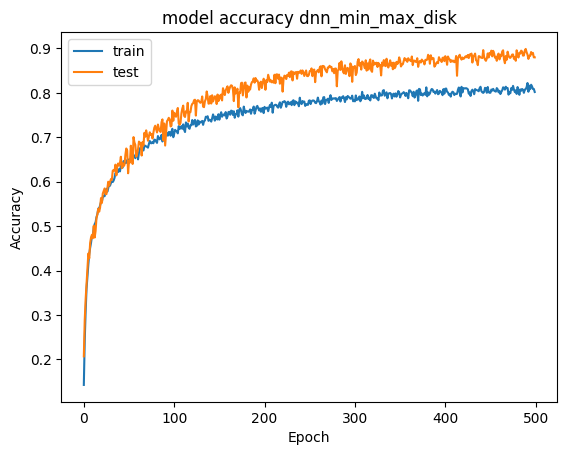

In [71]:
# base model
model = basemodel(len(reshaped_data))
history = train_dnn(model = model, X = np.squeeze(X_train, axis=2), Y = Y_train, test_X = np.squeeze(X_test, axis=2), test_Y = Y_test, cp_path = 'dnn_min_max_disk', Epoch=500)

2023-10-08 13:30:45.698760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 13:30:46.280186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18532 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


X shape :  (10320, 301, 1)
Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_layer (ResnetLayer)  multiple                  24484     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  2465920   
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  2080      
                                                                 
 dense_3 (Dense)             multiple                  561       
                                                                 
Total params: 2,501,301
Trainable

2023-10-08 13:30:49.162905: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-08 13:30:49.350942: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


323/323 [==============================] - ETA: 0s - loss: 1.9691 - accuracy: 0.3734 - categorical_crossentropy: 1.9691

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 13s 28ms/step - loss: 1.9691 - accuracy: 0.3734 - categorical_crossentropy: 1.9691 - val_loss: 2.0132 - val_accuracy: 0.3415 - val_categorical_crossentropy: 2.0132
Epoch 2/500
320/323 [============================>.] - ETA: 0s - loss: 0.6184 - accuracy: 0.7898 - categorical_crossentropy: 0.6184

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 25ms/step - loss: 0.6169 - accuracy: 0.7905 - categorical_crossentropy: 0.6169 - val_loss: 0.5172 - val_accuracy: 0.8353 - val_categorical_crossentropy: 0.5172
Epoch 3/500
322/323 [============================>.] - ETA: 0s - loss: 0.2431 - accuracy: 0.9187 - categorical_crossentropy: 0.2431

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.2429 - accuracy: 0.9188 - categorical_crossentropy: 0.2429 - val_loss: 0.2878 - val_accuracy: 0.9035 - val_categorical_crossentropy: 0.2878
Epoch 4/500
323/323 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9613 - categorical_crossentropy: 0.1218

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 25ms/step - loss: 0.1218 - accuracy: 0.9613 - categorical_crossentropy: 0.1218 - val_loss: 0.3479 - val_accuracy: 0.9039 - val_categorical_crossentropy: 0.3479
Epoch 5/500
323/323 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9586 - categorical_crossentropy: 0.1379

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 26ms/step - loss: 0.1379 - accuracy: 0.9586 - categorical_crossentropy: 0.1379 - val_loss: 0.3214 - val_accuracy: 0.9047 - val_categorical_crossentropy: 0.3214
Epoch 6/500
320/323 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9566 - categorical_crossentropy: 0.1427

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.1421 - accuracy: 0.9567 - categorical_crossentropy: 0.1421 - val_loss: 0.3194 - val_accuracy: 0.9120 - val_categorical_crossentropy: 0.3194
Epoch 7/500
323/323 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9684 - categorical_crossentropy: 0.1032

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 25ms/step - loss: 0.1032 - accuracy: 0.9684 - categorical_crossentropy: 0.1032 - val_loss: 0.3411 - val_accuracy: 0.9136 - val_categorical_crossentropy: 0.3411
Epoch 8/500
322/323 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9819 - categorical_crossentropy: 0.0621

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.0622 - accuracy: 0.9818 - categorical_crossentropy: 0.0622 - val_loss: 0.2338 - val_accuracy: 0.9391 - val_categorical_crossentropy: 0.2338
Epoch 9/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0434 - accuracy: 0.9871 - categorical_crossentropy: 0.0434 - val_loss: 0.2710 - val_accuracy: 0.9329 - val_categorical_crossentropy: 0.2710
Epoch 10/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0868 - accuracy: 0.9740 - categorical_crossentropy: 0.0868 - val_loss: 0.4148 - val_accuracy: 0.9023 - val_categorical_crossentropy: 0.4148
Epoch 11/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0880 - accuracy: 0.9748 - categorical_crossentropy: 0.0880 - val_loss: 0.4200 - val_accuracy: 0.9066 - val_categorical_crossentropy: 0.4200
Epoch 12/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0833 - accuracy: 0.9754 - categorical_crossentropy: 0.0833 

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.0518 - accuracy: 0.9847 - categorical_crossentropy: 0.0518 - val_loss: 0.2394 - val_accuracy: 0.9461 - val_categorical_crossentropy: 0.2394
Epoch 14/500
320/323 [============================>.] - ETA: 0s - loss: 0.0430 - accuracy: 0.9890 - categorical_crossentropy: 0.0430

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.0428 - accuracy: 0.9891 - categorical_crossentropy: 0.0428 - val_loss: 0.2087 - val_accuracy: 0.9488 - val_categorical_crossentropy: 0.2087
Epoch 15/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0674 - accuracy: 0.9826 - categorical_crossentropy: 0.0674 - val_loss: 0.2648 - val_accuracy: 0.9380 - val_categorical_crossentropy: 0.2648
Epoch 16/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0713 - accuracy: 0.9790 - categorical_crossentropy: 0.0713 - val_loss: 0.2887 - val_accuracy: 0.9240 - val_categorical_crossentropy: 0.2887
Epoch 17/500
320/323 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9895 - categorical_crossentropy: 0.0313

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.0311 - accuracy: 0.9895 - categorical_crossentropy: 0.0311 - val_loss: 0.1854 - val_accuracy: 0.9624 - val_categorical_crossentropy: 0.1854
Epoch 18/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0271 - accuracy: 0.9919 - categorical_crossentropy: 0.0271 - val_loss: 0.1961 - val_accuracy: 0.9558 - val_categorical_crossentropy: 0.1961
Epoch 19/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0814 - accuracy: 0.9817 - categorical_crossentropy: 0.0814 - val_loss: 0.3672 - val_accuracy: 0.9205 - val_categorical_crossentropy: 0.3672
Epoch 20/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0805 - accuracy: 0.9795 - categorical_crossentropy: 0.0805 - val_loss: 0.1773 - val_accuracy: 0.9609 - val_categorical_crossentropy: 0.1773
Epoch 21/500
321/323 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9921 - categorical_crossentropy: 0.0299

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.0299 - accuracy: 0.9921 - categorical_crossentropy: 0.0299 - val_loss: 0.1419 - val_accuracy: 0.9667 - val_categorical_crossentropy: 0.1419
Epoch 22/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0225 - accuracy: 0.9942 - categorical_crossentropy: 0.0225 - val_loss: 0.3570 - val_accuracy: 0.9415 - val_categorical_crossentropy: 0.3570
Epoch 23/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0703 - accuracy: 0.9837 - categorical_crossentropy: 0.0703 - val_loss: 0.4158 - val_accuracy: 0.9120 - val_categorical_crossentropy: 0.4158
Epoch 24/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0563 - accuracy: 0.9855 - categorical_crossentropy: 0.0563 - val_loss: 0.2077 - val_accuracy: 0.9601 - val_categorical_crossentropy: 0.2077
Epoch 25/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0225 - accuracy: 0.9936 - categorical_crossentropy: 0.0225

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.0246 - accuracy: 0.9930 - categorical_crossentropy: 0.0246 - val_loss: 0.1587 - val_accuracy: 0.9705 - val_categorical_crossentropy: 0.1587
Epoch 27/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0314 - accuracy: 0.9911 - categorical_crossentropy: 0.0314 - val_loss: 0.3041 - val_accuracy: 0.9438 - val_categorical_crossentropy: 0.3041
Epoch 28/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0575 - accuracy: 0.9857 - categorical_crossentropy: 0.0575 - val_loss: 0.1838 - val_accuracy: 0.9647 - val_categorical_crossentropy: 0.1838
Epoch 29/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0547 - accuracy: 0.9864 - categorical_crossentropy: 0.0547 - val_loss: 0.2490 - val_accuracy: 0.9504 - val_categorical_crossentropy: 0.2490
Epoch 30/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0325 - accuracy: 0.9921 - categorical_crossentropy: 0.0325

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.0144 - accuracy: 0.9953 - categorical_crossentropy: 0.0144 - val_loss: 0.1173 - val_accuracy: 0.9760 - val_categorical_crossentropy: 0.1173
Epoch 34/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0116 - accuracy: 0.9965 - categorical_crossentropy: 0.0116 - val_loss: 0.1344 - val_accuracy: 0.9729 - val_categorical_crossentropy: 0.1344
Epoch 35/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0364 - accuracy: 0.9923 - categorical_crossentropy: 0.0364 - val_loss: 0.1428 - val_accuracy: 0.9686 - val_categorical_crossentropy: 0.1428
Epoch 36/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0291 - accuracy: 0.9931 - categorical_crossentropy: 0.0291 - val_loss: 0.1804 - val_accuracy: 0.9682 - val_categorical_crossentropy: 0.1804
Epoch 37/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0165 - accuracy: 0.9962 - categorical_crossentropy: 0.0165

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.0237 - accuracy: 0.9934 - categorical_crossentropy: 0.0237 - val_loss: 0.1437 - val_accuracy: 0.9795 - val_categorical_crossentropy: 0.1437
Epoch 43/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0447 - accuracy: 0.9910 - categorical_crossentropy: 0.0447 - val_loss: 0.1448 - val_accuracy: 0.9655 - val_categorical_crossentropy: 0.1448
Epoch 44/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0349 - accuracy: 0.9925 - categorical_crossentropy: 0.0349 - val_loss: 0.3176 - val_accuracy: 0.9473 - val_categorical_crossentropy: 0.3176
Epoch 45/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0284 - accuracy: 0.9932 - categorical_crossentropy: 0.0284 - val_loss: 0.0933 - val_accuracy: 0.9764 - val_categorical_crossentropy: 0.0933
Epoch 46/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0534 - accuracy: 0.9894 - categorical_crossentropy: 0.0534

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 0.0040 - accuracy: 0.9986 - categorical_crossentropy: 0.0040 - val_loss: 0.0808 - val_accuracy: 0.9822 - val_categorical_crossentropy: 0.0808
Epoch 48/500
320/323 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9987 - categorical_crossentropy: 0.0036

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 25ms/step - loss: 0.0035 - accuracy: 0.9987 - categorical_crossentropy: 0.0035 - val_loss: 0.0579 - val_accuracy: 0.9857 - val_categorical_crossentropy: 0.0579
Epoch 49/500
323/323 [==============================] - ETA: 0s - loss: 1.3524e-04 - accuracy: 1.0000 - categorical_crossentropy: 1.3524e-04

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 1.3524e-04 - accuracy: 1.0000 - categorical_crossentropy: 1.3524e-04 - val_loss: 0.0573 - val_accuracy: 0.9868 - val_categorical_crossentropy: 0.0573
Epoch 50/500
323/323 [==============================] - 6s 17ms/step - loss: 4.7604e-05 - accuracy: 1.0000 - categorical_crossentropy: 4.7604e-05 - val_loss: 0.0557 - val_accuracy: 0.9868 - val_categorical_crossentropy: 0.0557
Epoch 51/500
323/323 [==============================] - 6s 18ms/step - loss: 3.4590e-05 - accuracy: 1.0000 - categorical_crossentropy: 3.4590e-05 - val_loss: 0.0541 - val_accuracy: 0.9868 - val_categorical_crossentropy: 0.0541
Epoch 52/500
320/323 [============================>.] - ETA: 0s - loss: 3.7122e-05 - accuracy: 1.0000 - categorical_crossentropy: 3.7122e-05

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 3.7045e-05 - accuracy: 1.0000 - categorical_crossentropy: 3.7045e-05 - val_loss: 0.0532 - val_accuracy: 0.9884 - val_categorical_crossentropy: 0.0532
Epoch 53/500
323/323 [==============================] - 6s 18ms/step - loss: 0.1339 - accuracy: 0.9740 - categorical_crossentropy: 0.1339 - val_loss: 0.3517 - val_accuracy: 0.9368 - val_categorical_crossentropy: 0.3517
Epoch 54/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0444 - accuracy: 0.9877 - categorical_crossentropy: 0.0444 - val_loss: 0.1314 - val_accuracy: 0.9694 - val_categorical_crossentropy: 0.1314
Epoch 55/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0086 - accuracy: 0.9979 - categorical_crossentropy: 0.0086 - val_loss: 0.0950 - val_accuracy: 0.9783 - val_categorical_crossentropy: 0.0950
Epoch 56/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0315 - accuracy: 0.9930 - categorical_crossentropy

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.0087 - accuracy: 0.9983 - categorical_crossentropy: 0.0087 - val_loss: 0.0490 - val_accuracy: 0.9907 - val_categorical_crossentropy: 0.0490
Epoch 100/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0105 - accuracy: 0.9982 - categorical_crossentropy: 0.0105 - val_loss: 0.1393 - val_accuracy: 0.9744 - val_categorical_crossentropy: 0.1393
Epoch 101/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0454 - accuracy: 0.9920 - categorical_crossentropy: 0.0454 - val_loss: 0.1194 - val_accuracy: 0.9771 - val_categorical_crossentropy: 0.1194
Epoch 102/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0260 - accuracy: 0.9949 - categorical_crossentropy: 0.0260 - val_loss: 0.1601 - val_accuracy: 0.9806 - val_categorical_crossentropy: 0.1601
Epoch 103/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0106 - accuracy: 0.9980 - categorical_crossentropy: 0.

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 9s 27ms/step - loss: 6.6885e-04 - accuracy: 0.9998 - categorical_crossentropy: 6.6885e-04 - val_loss: 0.0744 - val_accuracy: 0.9922 - val_categorical_crossentropy: 0.0744
Epoch 128/500
323/323 [==============================] - 6s 18ms/step - loss: 2.8977e-04 - accuracy: 0.9999 - categorical_crossentropy: 2.8977e-04 - val_loss: 0.0823 - val_accuracy: 0.9899 - val_categorical_crossentropy: 0.0823
Epoch 129/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0343 - accuracy: 0.9948 - categorical_crossentropy: 0.0343 - val_loss: 0.1315 - val_accuracy: 0.9806 - val_categorical_crossentropy: 0.1315
Epoch 130/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0124 - accuracy: 0.9980 - categorical_crossentropy: 0.0124 - val_loss: 0.0881 - val_accuracy: 0.9860 - val_categorical_crossentropy: 0.0881
Epoch 131/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0075 - accuracy: 0.9984 - categorical_

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


323/323 [==============================] - 8s 26ms/step - loss: 0.0030 - accuracy: 0.9996 - categorical_crossentropy: 0.0030 - val_loss: 0.1508 - val_accuracy: 0.9926 - val_categorical_crossentropy: 0.1508
Epoch 297/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0099 - accuracy: 0.9988 - categorical_crossentropy: 0.0099 - val_loss: 0.1853 - val_accuracy: 0.9872 - val_categorical_crossentropy: 0.1853
Epoch 298/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0179 - accuracy: 0.9993 - categorical_crossentropy: 0.0179 - val_loss: 0.2367 - val_accuracy: 0.9853 - val_categorical_crossentropy: 0.2367
Epoch 299/500
323/323 [==============================] - 6s 17ms/step - loss: 0.0099 - accuracy: 0.9989 - categorical_crossentropy: 0.0099 - val_loss: 0.2555 - val_accuracy: 0.9895 - val_categorical_crossentropy: 0.2555
Epoch 300/500
323/323 [==============================] - 6s 18ms/step - loss: 0.0111 - accuracy: 0.9992 - categorical_crossentropy: 0.

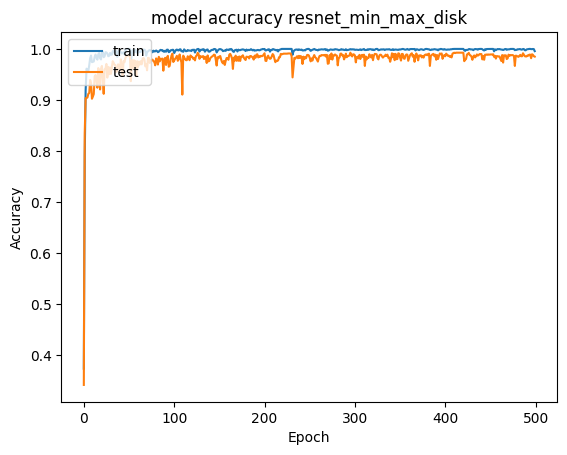

In [70]:
# non_norm_model = non_norm(len(range_fft_dict))

# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = [1, 32]
filter_out_list = [32, 64]
kernel_size = 3
# model = build_resnet(filter_in_list = filter_in_list, filter_out_list = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
history = train(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_min_max_disk', Epoch=500)

X shape :  (3264, 301, 1)
Model: "resnet_regression_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 resnet_layer_9 (ResnetLayer  multiple                 24484     
 )                                                               
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 dense_36 (Dense)            multiple                  2465920   
                                                                 
 dense_37 (Dense)            multiple                  8256      
                                                                 
 dense_38 (Dense)    

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 44ms/step - loss: 2401.3000 - mae: 12.0921 - mse: 2401.3000 - val_loss: 15.8238 - val_mae: 3.2392 - val_mse: 15.8238
Epoch 2/500
101/102 [============================>.] - ETA: 0s - loss: 14.6274 - mae: 3.0670 - mse: 14.6274

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 14.5460 - mae: 3.0572 - mse: 14.5460 - val_loss: 14.5178 - val_mae: 3.0693 - val_mse: 14.5178
Epoch 3/500
102/102 [==============================] - 2s 15ms/step - loss: 19.7360 - mae: 3.5608 - mse: 19.7360 - val_loss: 19.1450 - val_mae: 3.6171 - val_mse: 19.1450
Epoch 4/500
102/102 [==============================] - ETA: 0s - loss: 13.9346 - mae: 2.9841 - mse: 13.9346

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 13.9346 - mae: 2.9841 - mse: 13.9346 - val_loss: 12.4459 - val_mae: 2.8901 - val_mse: 12.4459
Epoch 5/500
102/102 [==============================] - 2s 16ms/step - loss: 20.8219 - mae: 3.6790 - mse: 20.8219 - val_loss: 16.5947 - val_mae: 3.3989 - val_mse: 16.5947
Epoch 6/500
102/102 [==============================] - 2s 15ms/step - loss: 15.7487 - mae: 3.1919 - mse: 15.7487 - val_loss: 27.3781 - val_mae: 4.4048 - val_mse: 27.3781
Epoch 7/500
102/102 [==============================] - 2s 15ms/step - loss: 20.9155 - mae: 3.6465 - mse: 20.9155 - val_loss: 30.0095 - val_mae: 4.6575 - val_mse: 30.0095
Epoch 8/500
102/102 [==============================] - 2s 15ms/step - loss: 13.3131 - mae: 2.9068 - mse: 13.3131 - val_loss: 13.7295 - val_mae: 3.0526 - val_mse: 13.7295
Epoch 9/500
102/102 [==============================] - 2s 15ms/step - loss: 14.2284 - mae: 3.0169 - mse: 14.2284 - val_loss: 13.9482 - val_mae: 2.9976 - val_mse: 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 12.6945 - mae: 2.8490 - mse: 12.6945 - val_loss: 8.9177 - val_mae: 2.4114 - val_mse: 8.9177
Epoch 11/500
102/102 [==============================] - 2s 16ms/step - loss: 15.0984 - mae: 3.1006 - mse: 15.0984 - val_loss: 20.8991 - val_mae: 3.8295 - val_mse: 20.8991
Epoch 12/500
100/102 [============================>.] - ETA: 0s - loss: 12.0503 - mae: 2.7765 - mse: 12.0503

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 11.9842 - mae: 2.7678 - mse: 11.9842 - val_loss: 7.7669 - val_mae: 2.2147 - val_mse: 7.7669
Epoch 13/500
100/102 [============================>.] - ETA: 0s - loss: 12.7857 - mae: 2.8585 - mse: 12.7857

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 12.7118 - mae: 2.8511 - mse: 12.7118 - val_loss: 7.1334 - val_mae: 2.1387 - val_mse: 7.1334
Epoch 14/500
102/102 [==============================] - 2s 16ms/step - loss: 12.6922 - mae: 2.8788 - mse: 12.6922 - val_loss: 9.9306 - val_mae: 2.5714 - val_mse: 9.9306
Epoch 15/500
102/102 [==============================] - 2s 16ms/step - loss: 15.4454 - mae: 3.1421 - mse: 15.4454 - val_loss: 16.1398 - val_mae: 3.3188 - val_mse: 16.1398
Epoch 16/500
102/102 [==============================] - 2s 16ms/step - loss: 7.7016 - mae: 2.2122 - mse: 7.7016 - val_loss: 8.9553 - val_mae: 2.4690 - val_mse: 8.9553
Epoch 17/500
101/102 [============================>.] - ETA: 0s - loss: 7.6659 - mae: 2.1861 - mse: 7.6659

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 7.6857 - mae: 2.1883 - mse: 7.6857 - val_loss: 5.0222 - val_mae: 1.7685 - val_mse: 5.0222
Epoch 18/500
100/102 [============================>.] - ETA: 0s - loss: 5.4965 - mae: 1.8478 - mse: 5.4965

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.5225 - mae: 1.8507 - mse: 5.5225 - val_loss: 4.8343 - val_mae: 1.7480 - val_mse: 4.8343
Epoch 19/500
101/102 [============================>.] - ETA: 0s - loss: 7.0941 - mae: 2.1085 - mse: 7.0941

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 7.1015 - mae: 2.1081 - mse: 7.1015 - val_loss: 4.7884 - val_mae: 1.7508 - val_mse: 4.7884
Epoch 20/500
101/102 [============================>.] - ETA: 0s - loss: 6.9637 - mae: 2.0916 - mse: 6.9637

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 6.9354 - mae: 2.0877 - mse: 6.9354 - val_loss: 4.6044 - val_mae: 1.7194 - val_mse: 4.6044
Epoch 21/500
102/102 [==============================] - 2s 15ms/step - loss: 6.0443 - mae: 1.9518 - mse: 6.0443 - val_loss: 6.9587 - val_mae: 2.1764 - val_mse: 6.9587
Epoch 22/500
 98/102 [===========================>..] - ETA: 0s - loss: 6.0539 - mae: 1.9375 - mse: 6.0539

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.9889 - mae: 1.9294 - mse: 5.9889 - val_loss: 4.0048 - val_mae: 1.5618 - val_mse: 4.0048
Epoch 23/500
102/102 [==============================] - 1s 14ms/step - loss: 5.9573 - mae: 1.9441 - mse: 5.9573 - val_loss: 4.0735 - val_mae: 1.5957 - val_mse: 4.0735
Epoch 24/500
102/102 [==============================] - ETA: 0s - loss: 4.3689 - mae: 1.6432 - mse: 4.3689

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 4.3689 - mae: 1.6432 - mse: 4.3689 - val_loss: 3.8140 - val_mae: 1.5498 - val_mse: 3.8140
Epoch 25/500
102/102 [==============================] - ETA: 0s - loss: 5.1409 - mae: 1.7960 - mse: 5.1409

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.1409 - mae: 1.7960 - mse: 5.1409 - val_loss: 3.7635 - val_mae: 1.5171 - val_mse: 3.7635
Epoch 26/500
102/102 [==============================] - 2s 15ms/step - loss: 3.5220 - mae: 1.4718 - mse: 3.5220 - val_loss: 4.4010 - val_mae: 1.6169 - val_mse: 4.4010
Epoch 27/500
102/102 [==============================] - 2s 15ms/step - loss: 4.0959 - mae: 1.5994 - mse: 4.0959 - val_loss: 5.0757 - val_mae: 1.7706 - val_mse: 5.0757
Epoch 28/500
102/102 [==============================] - 2s 16ms/step - loss: 3.5920 - mae: 1.4807 - mse: 3.5920 - val_loss: 4.2598 - val_mae: 1.6570 - val_mse: 4.2598
Epoch 29/500
102/102 [==============================] - 2s 15ms/step - loss: 3.3147 - mae: 1.4139 - mse: 3.3147 - val_loss: 3.8176 - val_mae: 1.5297 - val_mse: 3.8176
Epoch 30/500
102/102 [==============================] - 2s 15ms/step - loss: 2.9702 - mae: 1.3712 - mse: 2.9702 - val_loss: 5.2518 - val_mae: 1.7995 - val_mse: 5.2518
Epoch 31/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 3.1755 - mae: 1.4132 - mse: 3.1755 - val_loss: 2.8517 - val_mae: 1.3033 - val_mse: 2.8517
Epoch 32/500
102/102 [==============================] - 2s 15ms/step - loss: 4.2045 - mae: 1.6010 - mse: 4.2045 - val_loss: 3.3619 - val_mae: 1.4245 - val_mse: 3.3619
Epoch 33/500
102/102 [==============================] - 2s 15ms/step - loss: 26.6353 - mae: 2.2073 - mse: 26.6353 - val_loss: 52.5412 - val_mae: 6.1846 - val_mse: 52.5412
Epoch 34/500
102/102 [==============================] - 2s 15ms/step - loss: 16.3630 - mae: 3.1866 - mse: 16.3630 - val_loss: 7.4690 - val_mae: 2.2107 - val_mse: 7.4690
Epoch 35/500
102/102 [==============================] - 2s 15ms/step - loss: 7.1629 - mae: 2.1333 - mse: 7.1629 - val_loss: 5.9703 - val_mae: 1.9535 - val_mse: 5.9703
Epoch 36/500
102/102 [==============================] - 2s 15ms/step - loss: 5.6321 - mae: 1.8873 - mse: 5.6321 - val_loss: 5.5855 - val_mae: 1.8912 - val_mse: 5.5855
Epoch

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 2.3480 - mae: 1.1718 - mse: 2.3480 - val_loss: 2.7269 - val_mae: 1.2867 - val_mse: 2.7269
Epoch 47/500
102/102 [==============================] - 2s 16ms/step - loss: 2.4970 - mae: 1.2140 - mse: 2.4970 - val_loss: 2.7894 - val_mae: 1.3054 - val_mse: 2.7894
Epoch 48/500
102/102 [==============================] - 2s 16ms/step - loss: 1.8136 - mae: 1.0415 - mse: 1.8136 - val_loss: 2.7935 - val_mae: 1.3186 - val_mse: 2.7935
Epoch 49/500
100/102 [============================>.] - ETA: 0s - loss: 1.7052 - mae: 1.0098 - mse: 1.7052

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.7064 - mae: 1.0097 - mse: 1.7064 - val_loss: 2.5622 - val_mae: 1.2276 - val_mse: 2.5622
Epoch 50/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5787 - mae: 0.9696 - mse: 1.5787 - val_loss: 2.7976 - val_mae: 1.2829 - val_mse: 2.7976
Epoch 51/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5701 - mae: 0.9673 - mse: 1.5701 - val_loss: 3.6444 - val_mae: 1.5163 - val_mse: 3.6444
Epoch 52/500
100/102 [============================>.] - ETA: 0s - loss: 1.4416 - mae: 0.9162 - mse: 1.4416

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.4390 - mae: 0.9150 - mse: 1.4390 - val_loss: 2.3186 - val_mae: 1.1745 - val_mse: 2.3186
Epoch 53/500
100/102 [============================>.] - ETA: 0s - loss: 1.3655 - mae: 0.8975 - mse: 1.3655

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3667 - mae: 0.8983 - mse: 1.3667 - val_loss: 2.1679 - val_mae: 1.1323 - val_mse: 2.1679
Epoch 54/500
100/102 [============================>.] - ETA: 0s - loss: 1.3354 - mae: 0.8857 - mse: 1.3354

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3315 - mae: 0.8827 - mse: 1.3315 - val_loss: 2.0915 - val_mae: 1.1103 - val_mse: 2.0915
Epoch 55/500
102/102 [==============================] - ETA: 0s - loss: 1.2466 - mae: 0.8635 - mse: 1.2466

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 1.2466 - mae: 0.8635 - mse: 1.2466 - val_loss: 2.0906 - val_mae: 1.1227 - val_mse: 2.0906
Epoch 56/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1839 - mae: 0.8395 - mse: 1.1839 - val_loss: 2.0975 - val_mae: 1.0992 - val_mse: 2.0975
Epoch 57/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1663 - mae: 0.8272 - mse: 1.1663 - val_loss: 2.1728 - val_mae: 1.1209 - val_mse: 2.1728
Epoch 58/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0570 - mae: 0.7958 - mse: 1.0570

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 1.0597 - mae: 0.7978 - mse: 1.0597 - val_loss: 2.0608 - val_mae: 1.0786 - val_mse: 2.0608
Epoch 59/500
102/102 [==============================] - ETA: 0s - loss: 1.0617 - mae: 0.7927 - mse: 1.0617

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.0617 - mae: 0.7927 - mse: 1.0617 - val_loss: 1.9994 - val_mae: 1.0537 - val_mse: 1.9994
Epoch 60/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0775 - mae: 0.8073 - mse: 1.0775

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0783 - mae: 0.8048 - mse: 1.0783 - val_loss: 1.8571 - val_mae: 1.0353 - val_mse: 1.8571
Epoch 61/500
102/102 [==============================] - 2s 15ms/step - loss: 0.9244 - mae: 0.7421 - mse: 0.9244 - val_loss: 2.1956 - val_mae: 1.0946 - val_mse: 2.1956
Epoch 62/500
102/102 [==============================] - 2s 16ms/step - loss: 1.0096 - mae: 0.7771 - mse: 1.0096 - val_loss: 1.9496 - val_mae: 1.0115 - val_mse: 1.9496
Epoch 63/500
102/102 [==============================] - 2s 16ms/step - loss: 0.8798 - mae: 0.7230 - mse: 0.8798 - val_loss: 2.0643 - val_mae: 1.0614 - val_mse: 2.0643
Epoch 64/500
101/102 [============================>.] - ETA: 0s - loss: 1.0394 - mae: 0.7936 - mse: 1.0394

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0355 - mae: 0.7919 - mse: 1.0355 - val_loss: 1.7620 - val_mae: 0.9954 - val_mse: 1.7620
Epoch 65/500
102/102 [==============================] - 2s 16ms/step - loss: 0.7959 - mae: 0.6950 - mse: 0.7959 - val_loss: 1.7645 - val_mae: 0.9718 - val_mse: 1.7645
Epoch 66/500
102/102 [==============================] - 2s 15ms/step - loss: 0.7371 - mae: 0.6630 - mse: 0.7371 - val_loss: 1.9203 - val_mae: 1.0212 - val_mse: 1.9203
Epoch 67/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6738 - mae: 0.6340 - mse: 0.6738 - val_loss: 2.4361 - val_mae: 1.1748 - val_mse: 2.4361
Epoch 68/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6948 - mae: 0.6504 - mse: 0.6948 - val_loss: 1.9890 - val_mae: 1.0691 - val_mse: 1.9890
Epoch 69/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6613 - mae: 0.6334 - mse: 0.6613 - val_loss: 1.7711 - val_mae: 0.9445 - val_mse: 1.7711
Epoch 70/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.5873 - mae: 0.6016 - mse: 0.5873 - val_loss: 1.6692 - val_mae: 0.9076 - val_mse: 1.6692
Epoch 72/500
102/102 [==============================] - 2s 16ms/step - loss: 0.5919 - mae: 0.6010 - mse: 0.5919 - val_loss: 1.7299 - val_mae: 0.9568 - val_mse: 1.7299
Epoch 73/500
102/102 [==============================] - 2s 15ms/step - loss: 0.5886 - mae: 0.5914 - mse: 0.5886 - val_loss: 1.9116 - val_mae: 0.9903 - val_mse: 1.9116
Epoch 74/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8842 - mae: 0.7214 - mse: 0.8842 - val_loss: 1.9108 - val_mae: 0.9964 - val_mse: 1.9108
Epoch 75/500
 99/102 [============================>.] - ETA: 0s - loss: 0.8336 - mae: 0.7022 - mse: 0.8336

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 0.8333 - mae: 0.7012 - mse: 0.8333 - val_loss: 1.6159 - val_mae: 0.9169 - val_mse: 1.6159
Epoch 76/500
102/102 [==============================] - 2s 16ms/step - loss: 1.1816 - mae: 0.6743 - mse: 1.1816 - val_loss: 40.7677 - val_mae: 5.5069 - val_mse: 40.7677
Epoch 77/500
102/102 [==============================] - 2s 16ms/step - loss: 5.9906 - mae: 1.7720 - mse: 5.9906 - val_loss: 2.9087 - val_mae: 1.3010 - val_mse: 2.9087
Epoch 78/500
102/102 [==============================] - 2s 15ms/step - loss: 1.4412 - mae: 0.9344 - mse: 1.4412 - val_loss: 2.4674 - val_mae: 1.1493 - val_mse: 2.4674
Epoch 79/500
102/102 [==============================] - 2s 16ms/step - loss: 0.9602 - mae: 0.7657 - mse: 0.9602 - val_loss: 1.9764 - val_mae: 1.0591 - val_mse: 1.9764
Epoch 80/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8893 - mae: 0.7343 - mse: 0.8893 - val_loss: 3.2197 - val_mae: 1.4053 - val_mse: 3.2197
Epoch 81/

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.3521 - mae: 0.4658 - mse: 0.3521 - val_loss: 1.5476 - val_mae: 0.8887 - val_mse: 1.5476
Epoch 91/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3538 - mae: 0.4625 - mse: 0.3538 - val_loss: 1.6913 - val_mae: 0.9244 - val_mse: 1.6913
Epoch 92/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3257 - mae: 0.4453 - mse: 0.3257 - val_loss: 1.6662 - val_mae: 0.9235 - val_mse: 1.6662
Epoch 93/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2738 - mae: 0.4121 - mse: 0.2738 - val_loss: 1.6223 - val_mae: 0.8911 - val_mse: 1.6223
Epoch 94/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3095 - mae: 0.4347 - mse: 0.3095 - val_loss: 1.6591 - val_mae: 0.9007 - val_mse: 1.6591
Epoch 95/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2589 - mae: 0.3966 - mse: 0.2589 - val_loss: 1.6342 - val_mae: 0.9429 - val_mse: 1.6342
Epoch 96/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.2346 - mae: 0.3805 - mse: 0.2346 - val_loss: 1.4538 - val_mae: 0.8504 - val_mse: 1.4538
Epoch 97/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2443 - mae: 0.3851 - mse: 0.2443 - val_loss: 1.5887 - val_mae: 0.9225 - val_mse: 1.5887
Epoch 98/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2987 - mae: 0.4243 - mse: 0.2987 - val_loss: 1.7635 - val_mae: 0.9390 - val_mse: 1.7635
Epoch 99/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2681 - mae: 0.4074 - mse: 0.2681 - val_loss: 1.5148 - val_mae: 0.8814 - val_mse: 1.5148
Epoch 100/500
102/102 [==============================] - 2s 16ms/step - loss: 0.2506 - mae: 0.3946 - mse: 0.2506 - val_loss: 2.2511 - val_mae: 1.1555 - val_mse: 2.2511
Epoch 101/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3056 - mae: 0.4335 - mse: 0.3056 - val_loss: 1.5900 - val_mae: 0.8766 - val_mse: 1.5900
Epoch 102

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.2063 - mae: 0.3562 - mse: 0.2063 - val_loss: 1.4153 - val_mae: 0.8254 - val_mse: 1.4153
Epoch 115/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2116 - mae: 0.3539 - mse: 0.2116 - val_loss: 1.4323 - val_mae: 0.8305 - val_mse: 1.4323
Epoch 116/500
102/102 [==============================] - 1s 15ms/step - loss: 0.1794 - mae: 0.3293 - mse: 0.1794 - val_loss: 1.7712 - val_mae: 0.9259 - val_mse: 1.7712
Epoch 117/500
102/102 [==============================] - 1s 14ms/step - loss: 0.2000 - mae: 0.3515 - mse: 0.2000 - val_loss: 1.5928 - val_mae: 0.8922 - val_mse: 1.5928
Epoch 118/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1193 - mae: 0.2711 - mse: 0.1193 - val_loss: 1.5743 - val_mae: 0.8954 - val_mse: 1.5743
Epoch 119/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1577 - mae: 0.3078 - mse: 0.1577 - val_loss: 1.5170 - val_mae: 0.8411 - val_mse: 1.5170
Epoch 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 0.1364 - mae: 0.2925 - mse: 0.1364 - val_loss: 1.3583 - val_mae: 0.8101 - val_mse: 1.3583
Epoch 128/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0998 - mae: 0.2478 - mse: 0.0998 - val_loss: 1.3738 - val_mae: 0.8034 - val_mse: 1.3738
Epoch 129/500
 99/102 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.2330 - mse: 0.0893

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 45ms/step - loss: 0.0892 - mae: 0.2329 - mse: 0.0892 - val_loss: 1.3357 - val_mae: 0.8181 - val_mse: 1.3357
Epoch 130/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1050 - mae: 0.2560 - mse: 0.1050 - val_loss: 1.3729 - val_mae: 0.8145 - val_mse: 1.3729
Epoch 131/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0871 - mae: 0.2290 - mse: 0.0871 - val_loss: 1.4004 - val_mae: 0.8370 - val_mse: 1.4004
Epoch 132/500
100/102 [============================>.] - ETA: 0s - loss: 0.1009 - mae: 0.2522 - mse: 0.1009

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.1008 - mae: 0.2523 - mse: 0.1008 - val_loss: 1.3289 - val_mae: 0.8015 - val_mse: 1.3289
Epoch 133/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1040 - mae: 0.2531 - mse: 0.1040 - val_loss: 1.4490 - val_mae: 0.8293 - val_mse: 1.4490
Epoch 134/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0759 - mae: 0.2165 - mse: 0.0759 - val_loss: 1.3897 - val_mae: 0.8101 - val_mse: 1.3897
Epoch 135/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1438 - mae: 0.2855 - mse: 0.1438 - val_loss: 1.5011 - val_mae: 0.8399 - val_mse: 1.5011
Epoch 136/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6515 - mae: 0.5240 - mse: 0.6515 - val_loss: 5.0691 - val_mae: 1.7616 - val_mse: 5.0691
Epoch 137/500
102/102 [==============================] - 2s 15ms/step - loss: 1562.7550 - mae: 20.0757 - mse: 1562.7550 - val_loss: 21.8882 - val_mae: 3.9101 - val_mse: 21.88

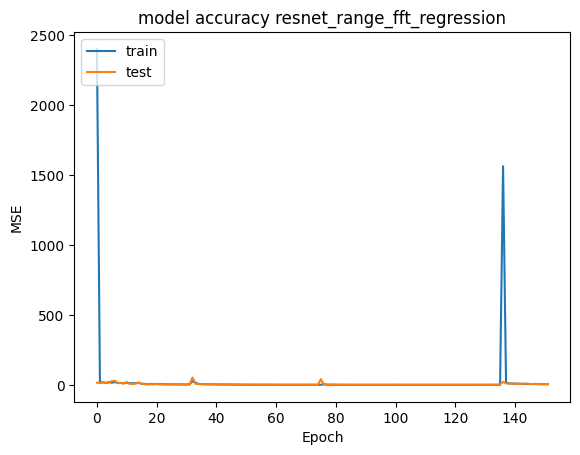

In [38]:
loss = tf.keras.losses.MeanSquaredError()
metrics = ['mae', 'mse']
model = Resnet_regression(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(range_fft_dict))
# reg_Y_train, reg_Y_test = np.argmax(Y_train, axis = 1), np.argmax(Y_test, axis = 1)
history = train_regression(model = model, X = X_train, Y = np.argmax(Y_train, axis=1), test_X = X_test, test_Y = np.argmax(Y_test, axis=1), cp_path = 'resnet_range_fft_regression', Epoch=500, loss = loss, metrics = metrics, monitor='val_mse', mode='min')